# Pendulum with Structured LNN and Control
- We know the data is angle and use it as advantage

## TODO:

- Plot Mass Matrix
- Plot Potential
- Understand the control

In [1]:
import numpy as np
import torch

import sys
sys.path.append("../../")

## Train Model

In [2]:
# hparams
num_data = 1000
batch_size = num_data
portion = 0.5

learning_rate = 3e-4
min_delta = 0
patience = 20

time_horizon = 1
solver = 'rk4'
# solver = 'dopri8'

model_name = 'LNN.pt'
# Check Model params in Model section

### Set Seed Here

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.manual_seed(0)

### Create the data set
- init_condition: list of tuple

 [(x0, p0, t0, t1, steps)]

In [4]:
from gym_env import PendulumCustomEnv
from data import Gym_DataModule_rng

In [5]:
env = PendulumCustomEnv(full_phase=True)
low = np.array([-2])
high = -low

# env, time step, traj, control
dataModule = Gym_DataModule_rng(env,
                                num_data,
                                low=low,
                                high=high,
                                portion=portion,
                                time_horizon=time_horizon,
                                batch_size=batch_size)

dataModule.setup()

/Users/fei/Documents/UCL/Thesis/Code/MBRL_HNN/experiment/Pendulum/../../data/generate_traj.py:257: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  extra.append(np.array([info['th'], info['dth'], info['ddth']]))


In [6]:
print(dataModule.dataset.tensors[0].shape)  # (bs, time, [cos q, sin, q, dq])
print(dataModule.dataset.tensors[1].shape)  # (bs, time, [control])
print(dataModule.dataset.tensors[2].shape)  # (bs, time, [time])
print(dataModule.dataset.tensors[3].shape)  # (bs, time, [th, dth, ddth])

torch.Size([1000, 1, 3])
torch.Size([1000, 1, 1])
torch.Size([1000, 1, 1])
torch.Size([1000, 1, 3])


In [7]:
dataModule.dataset.tensors[0].dtype

torch.float32

### Define Model

In [8]:
from torchdyn.models import NeuralODE

from module import LNN
from nn import MLP, PSD, MatrixNet

In [9]:
massMatrixNet = PSD([2, 64, 64, 1], activation='softplus')
potentialNet = MLP([2, 64, 64, 1], activation='softplus')
controlNet = MatrixNet([2, 64, 64, 1], control_dim=1, activation='sigmoid')

massMatrixNet.double()
potentialNet.double()
controlNet.double()

lagFunc = LNN(num_angle=1, 
              massMatrixNet=massMatrixNet,
              potentialNet=potentialNet,
              controlNet=controlNet).double()

lagODE = NeuralODE(lagFunc, sensitivity='adjoint', solver=solver).to(device).double()

### Pretrain with time horizon = 2

In [10]:
import torch.nn.functional as F

import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping

In [11]:
class Pre_learner(pl.LightningModule):
    def __init__(self, model: torch.nn.Module):
        super().__init__()
        self.model = model
        self.loss_func = F.mse_loss
        self.time_horizon = 2

    def forward(self, x):
        return self.model.defunc(0, x)

    def training_step(self, batch, batch_idx):
        x, u, t, _ = batch
        t_span = t[0, :self.time_horizon, 0]
        q_dq_u = torch.cat([x[:, :self.time_horizon, :], u[:, :self.time_horizon, :]], dim=2)  # Pick (q, dq, u)

        est = self.model.trajectory(q_dq_u[:, 0, :], t_span)

        loss = self.loss_func(q_dq_u, est.transpose(0, 1))
        
        self.logger.experiment.add_scalars("loss", {"train": loss}, self.current_epoch)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.model.parameters(), lr=learning_rate)

In [12]:
# pre_Learn = Pre_learner(lagODE)
# pre_trainer = pl.Trainer(max_epochs=10)
# pre_trainer.fit(pre_Learn, dataModule)

### Define Pytorch lightning trainer

In [13]:
class Learner(pl.LightningModule):
    def __init__(self, model: torch.nn.Module):
        super().__init__()
        self.model = model
        self.loss_func = F.mse_loss

    def forward(self, x):
        return self.model.defunc(0, x)

    def training_step(self, batch, batch_idx):
        x, u, t, infos = batch
        
        q_dq_u = torch.cat([x[:, :, :], u[:, :, :]], dim=2)
        t_span = t[0, :, 0]
        
        est = self.model.defunc(0, q_dq_u[:, 0, :])
        
        dcos = -np.sin(infos[:, 0, 0]) * infos[:, 0, 1]
        dsin = np.cos(infos[:, 0, 0]) * infos[:, 0, 1]
        ddq = infos[:, 0, 2]
        truth = torch.stack([dcos, dsin, ddq], axis=1)

        loss = self.loss_func(truth, est[:, 0:3])
        
        # loss = self.loss_func(infos[:, 0, 2], est[:, 2])

        # est = self.model.trajectory(q_dq_u[:, 0, :], t_span)

        # loss = self.loss_func(q_dq_u, est.transpose(0, 1))
        
        self.logger.experiment.add_scalars("loss", {"train": loss}, self.current_epoch)
        return loss

    def validation_step(self, batch, batch_idx):
        x, u, t, infos = batch

        q_dq_u = torch.cat([x[:, :, :], u[:, :, :]], dim=2)
        t_span = t[0, :, 0]
        
        est = self.model.defunc(0, q_dq_u[:, 0, :])
        
        dcos = -np.sin(infos[:, 0, 0]) * infos[:, 0, 1]
        dsin = np.cos(infos[:, 0, 0]) * infos[:, 0, 1]
        ddq = infos[:, 0, 2]
        truth = torch.stack([dcos, dsin, ddq], axis=1)

        loss = self.loss_func(truth, est[:, 0:3])
        
        # loss = self.loss_func(infos[:, 0, 2], est[:, 2])

        # est = self.model.trajectory(q_dq_u[:, 0, :], t_span)

        # loss = self.loss_func(q_dq_u, est.transpose(0, 1))
        
        self.log('val_loss', loss)
        self.logger.experiment.add_scalars("loss", {"val": loss}, self.current_epoch)
        return loss
    

    def configure_optimizers(self):
        return torch.optim.Adam(self.model.parameters(), lr=learning_rate)

In [14]:
learn = Learner(lagODE)

early_stopping = EarlyStopping('val_loss', verbose=True, min_delta=min_delta, patience=patience)
trainer = pl.Trainer(callbacks=[early_stopping], min_epochs=100, max_epochs=5000, precision=64)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores


### Train

In [15]:
trainer.fit(learn, dataModule)


  | Name  | Type      | Params
------------------------------------
0 | model | NeuralODE | 13.3 K
------------------------------------
13.3 K    Trainable params
0         Non-trainable params
13.3 K    Total params
0.106     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/Users/fei/miniconda3/envs/mbrlhnn/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:348: UserWarning: Your val_dataloader has `shuffle=True`, it is best practice to turn this off for val/test/predict dataloaders.
  rank_zero_warn(
/Users/fei/miniconda3/envs/mbrlhnn/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/fei/miniconda3/envs/mbrlhnn/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to impro

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 18.720
/Users/fei/miniconda3/envs/mbrlhnn/lib/python3.8/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:610: LightningDeprecationWarning: Relying on `self.log('val_loss', ...)` to set the ModelCheckpoint monitor is deprecated in v1.2 and will be removed in v1.4. Please, create your own `mc = ModelCheckpoint(monitor='your_monitor')` and use it as `Trainer(callbacks=[mc])`.
  warning_cache.deprecation(


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.060 >= min_delta = 0. New best score: 18.660


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.060 >= min_delta = 0. New best score: 18.600


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.061 >= min_delta = 0. New best score: 18.539


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.061 >= min_delta = 0. New best score: 18.478


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.062 >= min_delta = 0. New best score: 18.416


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.063 >= min_delta = 0. New best score: 18.353


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.064 >= min_delta = 0. New best score: 18.289


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.066 >= min_delta = 0. New best score: 18.222


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.068 >= min_delta = 0. New best score: 18.155


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.070 >= min_delta = 0. New best score: 18.084


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.073 >= min_delta = 0. New best score: 18.012


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.076 >= min_delta = 0. New best score: 17.936


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.079 >= min_delta = 0. New best score: 17.857


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.083 >= min_delta = 0. New best score: 17.774


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.087 >= min_delta = 0. New best score: 17.688


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.091 >= min_delta = 0. New best score: 17.596


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.096 >= min_delta = 0. New best score: 17.500


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.102 >= min_delta = 0. New best score: 17.398


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.108 >= min_delta = 0. New best score: 17.290


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.115 >= min_delta = 0. New best score: 17.175


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.122 >= min_delta = 0. New best score: 17.053


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.130 >= min_delta = 0. New best score: 16.923


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.138 >= min_delta = 0. New best score: 16.785


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.146 >= min_delta = 0. New best score: 16.639


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.155 >= min_delta = 0. New best score: 16.483


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.165 >= min_delta = 0. New best score: 16.319


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.175 >= min_delta = 0. New best score: 16.144


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.186 >= min_delta = 0. New best score: 15.958


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.197 >= min_delta = 0. New best score: 15.761


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.210 >= min_delta = 0. New best score: 15.551


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.224 >= min_delta = 0. New best score: 15.326


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.239 >= min_delta = 0. New best score: 15.087


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.255 >= min_delta = 0. New best score: 14.832


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.272 >= min_delta = 0. New best score: 14.560


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.290 >= min_delta = 0. New best score: 14.269


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.310 >= min_delta = 0. New best score: 13.960


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.331 >= min_delta = 0. New best score: 13.629


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.356 >= min_delta = 0. New best score: 13.272


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.386 >= min_delta = 0. New best score: 12.886


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.420 >= min_delta = 0. New best score: 12.466


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.455 >= min_delta = 0. New best score: 12.011


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.487 >= min_delta = 0. New best score: 11.524


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.512 >= min_delta = 0. New best score: 11.011


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.530 >= min_delta = 0. New best score: 10.481


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.539 >= min_delta = 0. New best score: 9.942


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.537 >= min_delta = 0. New best score: 9.406


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.527 >= min_delta = 0. New best score: 8.879


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.513 >= min_delta = 0. New best score: 8.365


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.498 >= min_delta = 0. New best score: 7.867


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.483 >= min_delta = 0. New best score: 7.384


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.469 >= min_delta = 0. New best score: 6.915


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.460 >= min_delta = 0. New best score: 6.455


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.454 >= min_delta = 0. New best score: 6.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.443 >= min_delta = 0. New best score: 5.557


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.423 >= min_delta = 0. New best score: 5.134


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.392 >= min_delta = 0. New best score: 4.742


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.354 >= min_delta = 0. New best score: 4.388


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.314 >= min_delta = 0. New best score: 4.074


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.276 >= min_delta = 0. New best score: 3.798


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.241 >= min_delta = 0. New best score: 3.557


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.211 >= min_delta = 0. New best score: 3.347


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.184 >= min_delta = 0. New best score: 3.162


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.159 >= min_delta = 0. New best score: 3.003


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.132 >= min_delta = 0. New best score: 2.871


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.103 >= min_delta = 0. New best score: 2.768


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.076 >= min_delta = 0. New best score: 2.692


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.053 >= min_delta = 0. New best score: 2.639


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.035 >= min_delta = 0. New best score: 2.604


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.020 >= min_delta = 0. New best score: 2.583


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.009 >= min_delta = 0. New best score: 2.574


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.574


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.008 >= min_delta = 0. New best score: 2.566


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.010 >= min_delta = 0. New best score: 2.556


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.010 >= min_delta = 0. New best score: 2.546


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.009 >= min_delta = 0. New best score: 2.537


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.008 >= min_delta = 0. New best score: 2.529


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.007 >= min_delta = 0. New best score: 2.522


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.006 >= min_delta = 0. New best score: 2.516


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.005 >= min_delta = 0. New best score: 2.511


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.004 >= min_delta = 0. New best score: 2.507


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.004 >= min_delta = 0. New best score: 2.503


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.003 >= min_delta = 0. New best score: 2.501


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0. New best score: 2.498


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0. New best score: 2.497


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0. New best score: 2.496


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0. New best score: 2.495


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0. New best score: 2.494


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0. New best score: 2.493


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0. New best score: 2.492


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0. New best score: 2.491


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0. New best score: 2.490


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.490


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0. New best score: 2.489


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0. New best score: 2.489


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0. New best score: 2.488


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0. New best score: 2.487


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0. New best score: 2.487


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.486


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.486


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.485


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.485


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.485


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.484


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.484


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.484


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.483


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.483


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.483


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.482


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.482


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.482


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.482


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.481


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.481


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.481


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.481


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.481


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.480


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.480


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.480


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.480


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.480


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.480


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.480


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.480


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.480


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.479


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.479


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.479


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.479


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.479


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.479


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.479


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.478


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.478


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.478


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.478


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.478


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.478


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.478


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.477


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.477


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.477


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.477


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.477


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.477


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.477


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.477


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.477


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.476


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.476


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.476


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.476


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.476


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.476


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.476


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.476


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.476


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.476


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.476


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.476


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.475


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.475


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.475


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.475


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.475


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.475


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.475


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.475


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.475


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.475


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.475


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.475


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.475


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.475


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.474


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.474


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.474


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.474


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.474


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.474


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.474


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.474


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.474


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.474


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.474


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.474


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.474


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.474


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.474


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.474


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.474


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.473


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.473


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.473


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.473


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.473


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.473


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.473


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.473


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.473


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.473


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.473


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.473


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.473


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.473


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.473


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.473


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.473


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.473


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.473


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.473


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.473


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.473


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.473


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.473


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.472


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.472


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.472


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.472


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.472


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.472


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.472


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.472


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.472


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.472


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.472


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.472


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.472


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.472


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.472


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.472


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.472


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.472


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.472


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.472


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.472


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.472


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.472


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.472


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.472


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.472


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.472


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.472


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.472


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.472


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.472


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.472


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.472


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.472


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.472


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.472


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.472


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.472


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.472


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.472


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.472


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.472


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.471


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 2.470


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 20 records. Best score: 2.470. Signaling Trainer to stop.


### Save Model
- Pytorch Lightning model check point is buggy
- Use Pytorch save and load method instead

In [16]:
torch.save(lagODE, 'models/{}'.format(model_name))

## Model Analysis

In [17]:
import matplotlib.pyplot as plt
from matplotlib.ticker import LinearLocator

### Load Model

In [18]:
test_model = torch.load('models/{}'.format(model_name))
test_model.eval()

test_model = test_model

### Generate trajectory with Gym Env

In [19]:
# define testing time stamp
dt = 0.05
full = 1000
t_span = torch.linspace(dt, dt*full, full)

In [20]:
# Generate Trajectory
env.seed(0)
np.random.seed(0)

env = PendulumCustomEnv()
obs = []
infos = []

# control = 2
# controls = np.random.randint(-2, 2 + 1, full+1)
split = 20
controls = np.random.randint(-2, 2 + 1, int(full / split))
controls = np.repeat(controls, split)
# controls = np.zeros_like(controls)

obs0, _ = env.reset(np.array([3., 1.]))
# obs0, _ = env.reset(np.array([3., 0]))

prev_obs = obs0
for i in range(full):
    obs.append(prev_obs)
    
    next_obs, reward, done, info = env.step(controls[i])
    infos.append(np.array([info['th'], info['dth'], info['ddth']]))
    prev_obs = next_obs

obs = torch.tensor(obs)
infos = torch.tensor(infos)
controls = torch.Tensor(controls).view(-1, 1)

### Generate Prediction

In [29]:
from utils import traj_pred

# Generate prediction
q_dq_u = torch.cat([obs, controls], dim=1)
est_grad = test_model.defunc(0, q_dq_u)
est = traj_pred(0.05, test_model, obs0, controls)

In [22]:
from scipy.integrate import solve_ivp

def dummy(t, y):
    idx = int(torch.tensor(t) / dt)
    dx1 = np.multiply(-y[1], y[2])
    dx2 = np.multiply(y[0], y[2])
    ddq = -10 * y[0] + controls[idx-1] / 2.
    return [dx1, dx2, ddq]

sol = solve_ivp(dummy, [dt, dt*full], obs0, method='DOP853', t_eval=t_span.detach().numpy())

### Check gradient

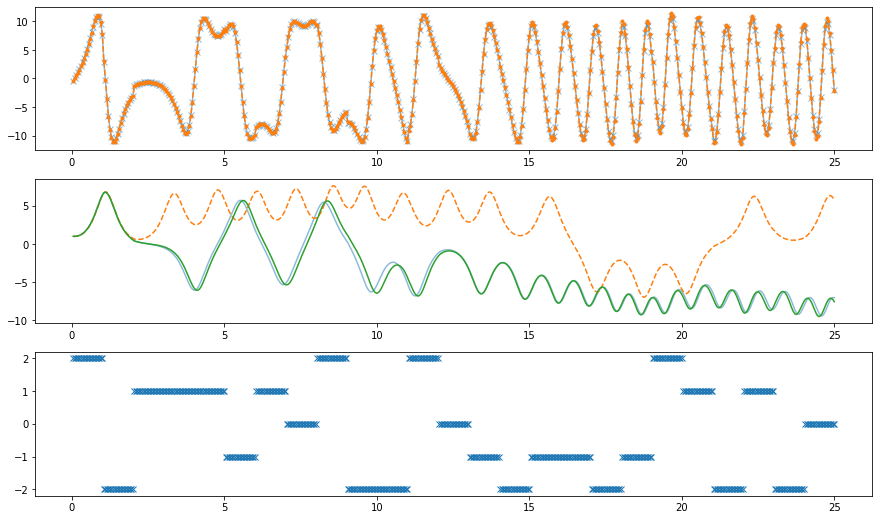

In [23]:
fig = plt.figure(figsize=(15, 9))
ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(312)
ax3 = fig.add_subplot(313)

start = 0
end = 500

# Check ddq_est
ax1.plot(t_span.detach().numpy()[start:end], infos[start:end, 2],'x-', alpha=0.5)  # Ground truth
ax1.plot(t_span.detach().numpy()[start:end], est_grad[start:end, 2].detach().numpy(), '.--')  # LNN

# check dq_est
ax2.plot(t_span.detach().numpy()[start:end], infos[start:end, 1],'-', alpha=0.5)
ax2.plot(t_span.detach().numpy()[start:end], est.y[2, start:end], '--')  # LNN
ax2.plot(sol.t[start:end], sol.y[2, start:end])

# Plot control for reference
ax3.plot(t_span.detach().numpy()[start:end], controls[start:end],'x')
# None

### Check trajectory

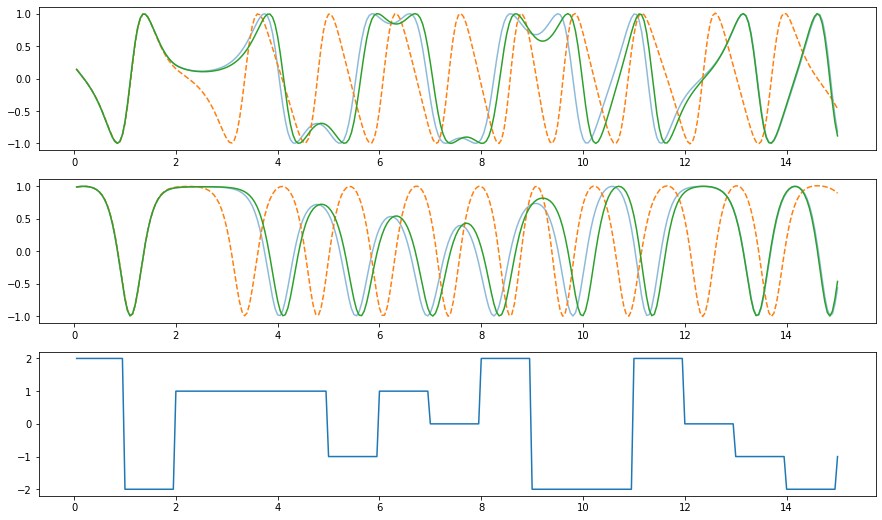

In [24]:
# Check trajectory
start = 0
end = 300

fig = plt.figure(figsize=(15, 9))
ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(312)
ax3 = fig.add_subplot(313)

# Plot cos q = x
ax1.plot(t_span.detach().numpy()[start:end], obs[start:end, 0].detach().numpy(), alpha=0.5)
ax1.plot(t_span.detach().numpy()[start:end], est.y[0, start:end], '--')
ax1.plot(sol.t[start:end], sol.y[0, start:end])

# Plot sin q = y
ax2.plot(t_span.detach().numpy()[start:end], obs[start:end, 1].detach().numpy(), alpha=0.5)
ax2.plot(t_span.detach().numpy()[start:end], est.y[1, start:end], '--')
ax2.plot(sol.t[start:end], sol.y[1, start:end])

# Plot control for reference
ax3.plot(t_span.detach().numpy()[start:end], controls[start+1:end+1])
# None
None

### Plot Phase Space Trajectory

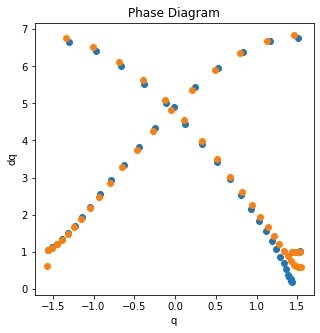

In [25]:
length = 45
# Plot Phase Space traj
th = torch.atan(obs[:length, 1] / obs[:length, 0])
thdot = obs[:length, 2]

est_th = torch.atan(torch.tensor(est.y[1, :length] / est.y[0, :length]))
est_thdot = est.y[2, :length]

fig, ax = plt.subplots(figsize=(5,5))
plt.scatter(th, thdot)
plt.scatter(est_th, est_thdot)

ax.set_xlabel("q")
ax.set_ylabel("dq")
ax.set_title("Phase Diagram")
None

### Plot Mass Matrix

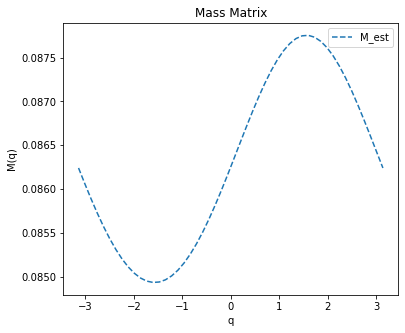

In [26]:
n_grid = 50
x = torch.linspace(-np.pi, np.pi, n_grid).double()

M_est = torch.zeros(x.shape)

for i in range(n_grid):
    q = torch.stack([torch.cos(x[i]), torch.sin(x[i])])
    M_est[i] = test_model.defunc.m.massMatrixNet(q.view(1, -1)).detach().cpu()[0, 0, 0]

    
M_true = torch.ones(M_est.shape)

fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111)
ax.plot(x.detach().numpy(), M_est, '--', label='M_est')
# ax.plot(x.detach().numpy(), M_true, label='M_true', alpha=0.5)

ax.legend()
# ax.set_ylim([0, 1.1])
ax.set_xlabel("q")
ax.set_ylabel("M(q)")
ax.set_title("Mass Matrix")
None

### Plot Potential

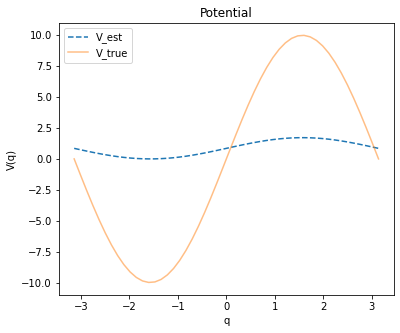

In [27]:
n_grid = 50
x = torch.linspace(-np.pi, np.pi, n_grid).double()

V_true = 1. * 10 * torch.sin(x)

V_est = torch.zeros(x.shape)

for i in range(n_grid):
    q = torch.stack([torch.cos(x[i]), torch.sin(x[i])])
    V_est[i] = test_model.defunc.m.potentialNet(q.view(1, -1)).detach().cpu()

V_est = V_est - min(V_est)

fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111)
ax.plot(x.detach().numpy(), V_est, '--', label='V_est')
ax.plot(x.detach().numpy(), V_true, label='V_true', alpha=0.5)

ax.legend()
ax.set_xlabel("q")
ax.set_ylabel("V(q)")
ax.set_title("Potential")
None

### Plot Control

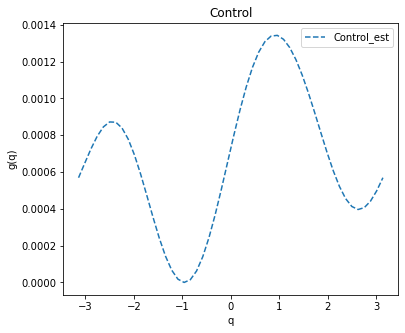

In [28]:
n_grid = 50
x = torch.linspace(-np.pi, np.pi, n_grid).double()
x1, x2 = torch.meshgrid(x, x)  # (cos q, sin q)

Control = 1. * 10 * torch.ones_like(x)

V_est = torch.zeros(x.shape)

for i in range(n_grid):
    q = torch.stack([torch.cos(x[i]), torch.sin(x[i])])
    V_est[i] = test_model.defunc.m.controlNet(q.view(1, -1)).detach().cpu()

V_est = V_est - min(V_est)

fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111)
ax.plot(x.detach().numpy(), V_est, '--', label='Control_est')
# ax.plot(x.detach().numpy(), V_true, label='V_true', alpha=0.5)

ax.legend()
ax.set_xlabel("q")
ax.set_ylabel("g(q)")
ax.set_title("Control")
None

## Conclusion